<a href="https://colab.research.google.com/github/AraiKensuke/AIiRPS/blob/master/PredictAQshort.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Predicting AQ-Short and its subfactors**


# Get code from Github
This notebook is largely the same as RPS_AQ28corr.py    if you want to run it from command line locally.

In [9]:
#########  clone and install necessary packages from github repositories

import sys
import importlib

if importlib.util.find_spec("AIiRPS") is None:
  !git clone https://github.com/AraiKensuke/AIiRPS.git

sys.path.insert(1, "/content/AIiRPS")


# Some functions

Functions that attempt to do somethings about outliers.

In [15]:
import numpy as _N  #  must import this before pyPG when running from shell
import pickle
import os
os.environ["AIiRPS_on_colab"] = "1"    #  do this before importing read_taisen

#!/usr/bin/python

from sklearn import linear_model
import sklearn.linear_model as _skl
import numpy as _N
import AIiRPS.utils.read_taisen as _rt
import scipy.io as _scio
import scipy.stats as _ss
import matplotlib.pyplot as _plt

import os
import sys
import pickle
import AIiRPS.rpsms as rpsms

import AIiRPS.constants as _cnst
from AIiRPS.utils.dir_util import getResultFN
import AIiRPS.models.CRutils as _crut

import matplotlib.ticker as ticker

def unskew(dat):
    sk = _N.empty(15)
    im = -1
    ms = _N.linspace(0.01, 1.1, 15)
    for m in ms:
        im += 1
        sk[im] = _ss.skew(_N.exp(dat / (m*_N.mean(dat))))
    min_im = _N.where(_N.abs(sk) == _N.min(_N.abs(sk)))[0][0]
    return _N.exp(dat / (ms[min_im]*_N.mean(dat)))

def standardize(y):
    ys = y - _N.mean(y)
    ys /= _N.std(ys)
    return ys


def depickle(s):
     import pickle
     with open(s, "rb") as f:
          lm = pickle.load(f)
     return lm

def wnd_mean(x, y, winsz=4, mode=1, wins=8):
    if mode == 1:
        ix = x.argsort()

        xwm = _N.empty(x.shape[0] - (winsz-1))  #  5 - (3-1)
        ywm = _N.empty(x.shape[0] - (winsz-1))  #  5 - (3-1)
        
        for i in range(x.shape[0] - (winsz-1)):
            xwm[i] = _N.mean(x[ix[i:i+winsz]])
            ywm[i] = _N.mean(y[ix[i:i+winsz]])
        return xwm, ywm
    else:
        x_min = _N.min(x) 
        x_max = _N.max(x)
        x_min -= 0.1*(x_max - x_min)/wins
        x_max += 0.1*(x_max - x_min)/wins

        dx    = (x_max - x_min) / wins

        xwm = _N.empty(wins)  #  5 - (3-1)
        ywm = _N.empty(wins)  #  5 - (3-1)
        
        xl = x_min
        for iw in range(wins):
            ths = _N.where((x >= xl) & (x < xl + dx))[0]
            xwm[iw] = _N.mean(x[ths])
            ywm[iw] = _N.mean(y[ths])
            xl += dx
            
        return xwm, ywm
        
def interiorCC(x, y):
    ix = x.argsort()
    iy = y.argsort()    

    ths = _N.array([ix[0], ix[-1], iy[0], iy[-1]])
    ths_unq = _N.unique(ths)
    interiorPts = _N.setdiff1d(_N.arange(len(x)), ths_unq)
    return _ss.pearsonr(x[interiorPts], y[interiorPts])

def rm_outliersCC_orig(x, y):
    ix = x.argsort()
    iy = y.argsort()    
    L = len(x)
    x_std = _N.std(x)
    y_std = _N.std(y)
    rmv   = []
    i = 0
    while x[ix[i+1]] - x[ix[i]] > 0.5*x_std:
        rmv.append(ix[i])
        i+= 1
    i = 0
    while x[ix[L-1-i]] - x[ix[L-1-i-1]] > 0.5*x_std:
        rmv.append(ix[L-1-i])
        i+= 1
    i = 0
    while y[iy[i+1]] - y[iy[i]] > 0.5*y_std:
        rmv.append(iy[i])
        i+= 1
    i = 0
    while y[iy[L-1-i]] - y[iy[L-1-i-1]] > 0.5*y_std:
        rmv.append(iy[L-1-i])
        i+= 1
        
    ths = _N.array(rmv)
    ths_unq = _N.unique(ths)
    interiorPts = _N.setdiff1d(_N.arange(len(x)), ths_unq)
    #print("%(ths)d" % {"ths" : len(ths)})
    return _ss.pearsonr(x[interiorPts], y[interiorPts])

def rm_outliersCC_neighbors(x, y):
    ix = x.argsort()
    iy = y.argsort()
    dsx = _N.mean(_N.diff(_N.sort(x)))
    dsy = _N.mean(_N.diff(_N.sort(y)))

    L = len(x)
    x_std = _N.std(x)
    y_std = _N.std(y)
    rmv   = []
    i = 0
    while x[ix[i+1]] - x[ix[i]] > 4*dsx:
        rmv.append(ix[i])
        i+= 1
    i = 0
    while x[ix[L-1-i]] - x[ix[L-1-i-1]] > 4*dsx:
        rmv.append(ix[L-1-i])
        i+= 1
    i = 0
    while y[iy[i+1]] - y[iy[i]] > 4*dsy:
        rmv.append(iy[i])
        i+= 1
    i = 0
    while y[iy[L-1-i]] - y[iy[L-1-i-1]] > 4*dsy:
        rmv.append(iy[L-1-i])
        i+= 1
        
    ths = _N.array(rmv)
    ths_unq = _N.unique(ths)
    interiorPts = _N.setdiff1d(_N.arange(len(x)), ths_unq)
    #print("%(ths)d" % {"ths" : len(ths)})
    return _ss.pearsonr(x[interiorPts], y[interiorPts])

def rm_outliersCC(x, y):
    ix = x.argsort()
    iy = y.argsort()    
    L = len(x)
    x_std = _N.std(x)
    y_std = _N.std(y)
    rmv   = []
    i = 0
    rmvd = 0
    while x[ix[i+1]] - x[ix[i]] > x_std:
        #rmvd += 1
        #rmv.append(ix[i])
        i+= 1
    i = 0
    while x[ix[L-1-i]] - x[ix[L-1-i-1]] > x_std:
        #rmvd += 1        
        #rmv.append(ix[L-1-i])
        i+= 1
    i = 0
    while y[iy[i+1]] - y[iy[i]] > y_std:
        #rmvd += 1        
        #rmv.append(iy[i])
        y[iy[i]] = y[iy[i+1]] - y_std*0.2
        i+= 1
    i = 0
    while y[iy[L-1-i]] - y[iy[L-1-i-1]] > y_std:
        #rmvd += 1        
        #rmv.append(iy[L-1-i])
        y[iy[L-1-i]] = y[L-1-i-1] + y_std*0.2
        i+= 1
        
    ths = _N.array(rmv)
    ths_unq = _N.unique(ths)
    interiorPts = _N.setdiff1d(_N.arange(len(x)), ths_unq)
    #print("%(ths)d" % {"ths" : len(ths)})
    return rmvd, x[interiorPts], y[interiorPts]#, _ss.pearsonr(x[interiorPts], y[interiorPts])
 


#  Open the pickle, extract and rescale features, plot simple correlation coefficient between features and AQ-Short

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:71: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

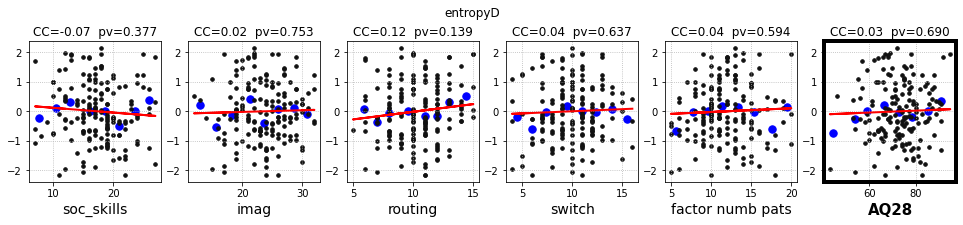

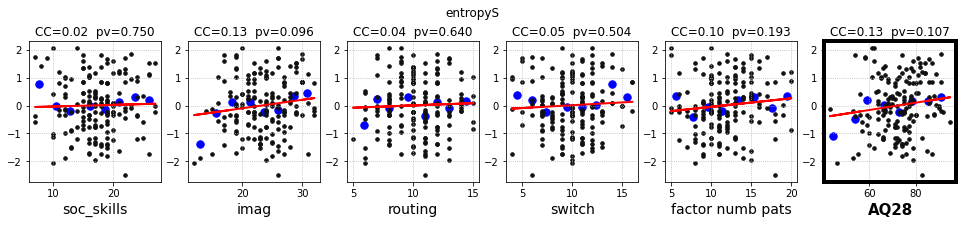

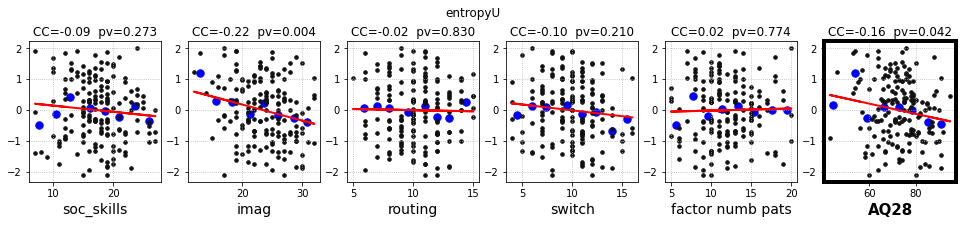

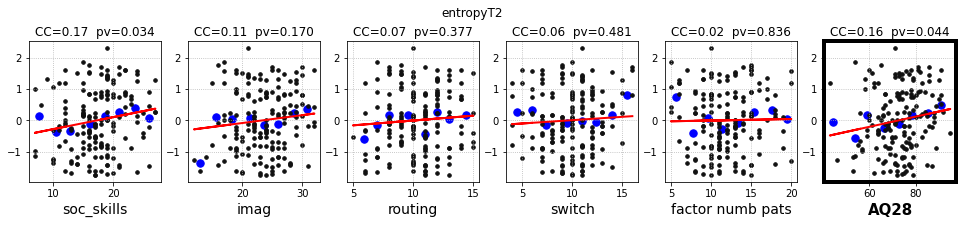

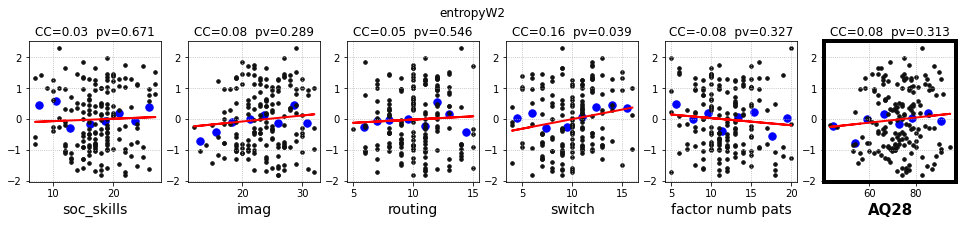

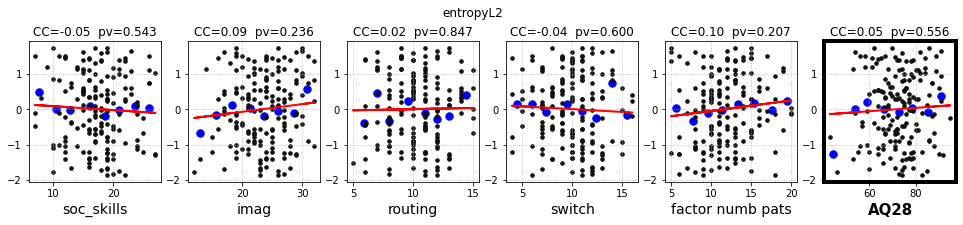

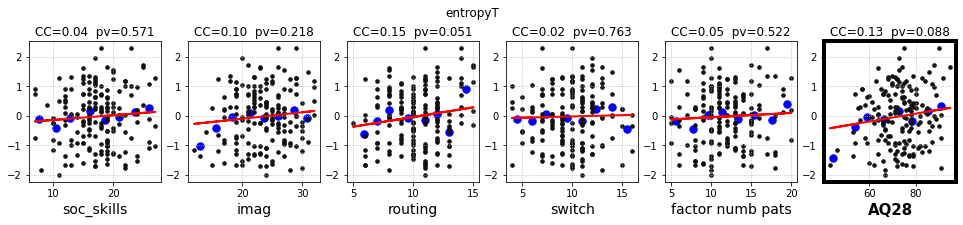

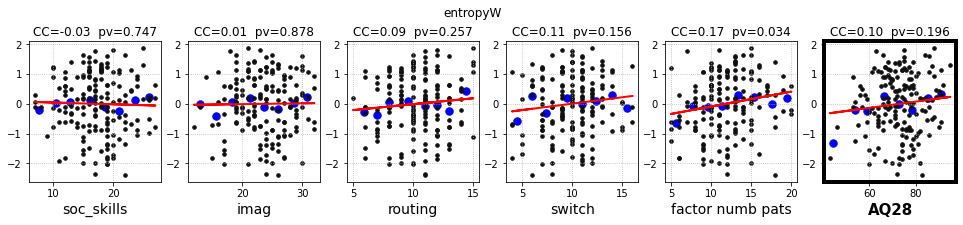

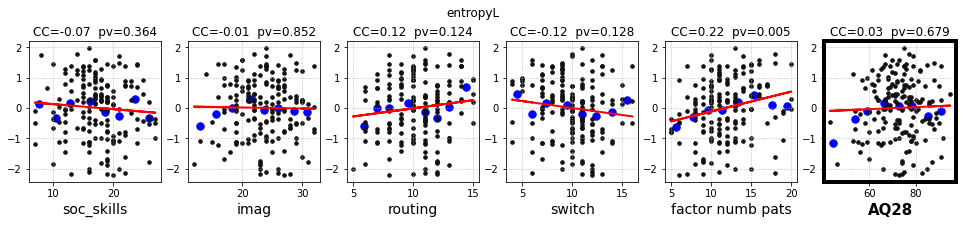

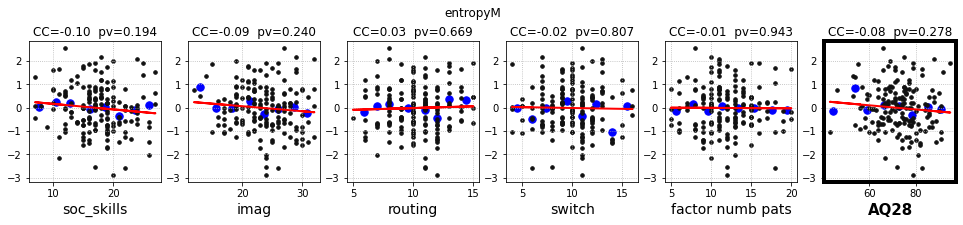

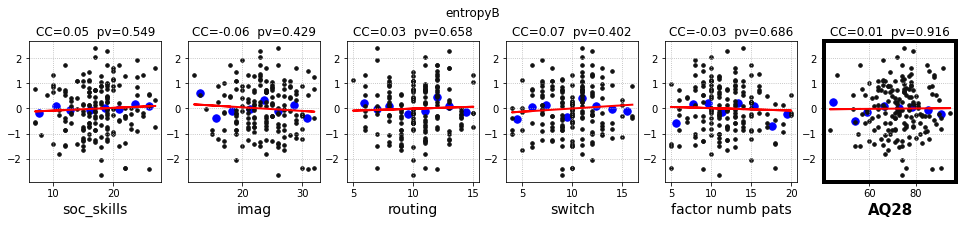

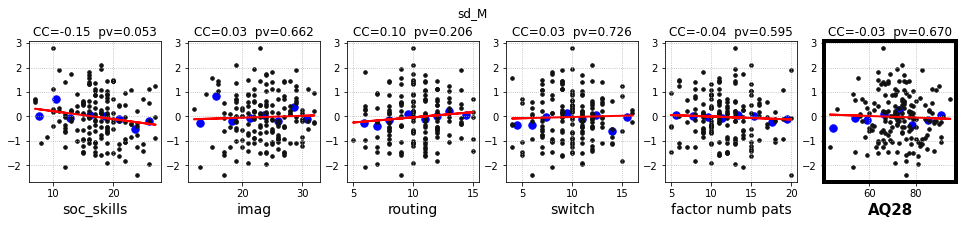

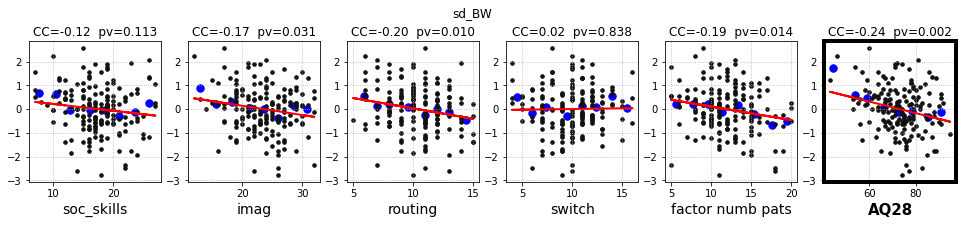

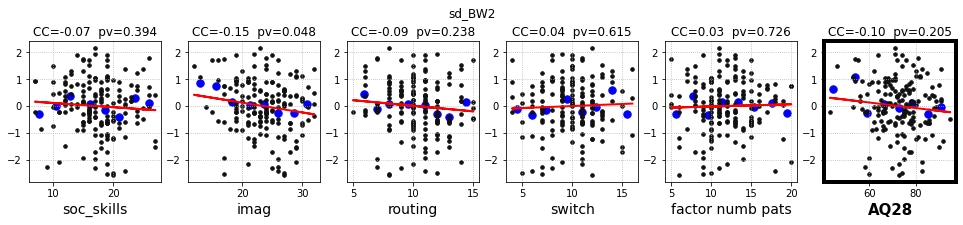

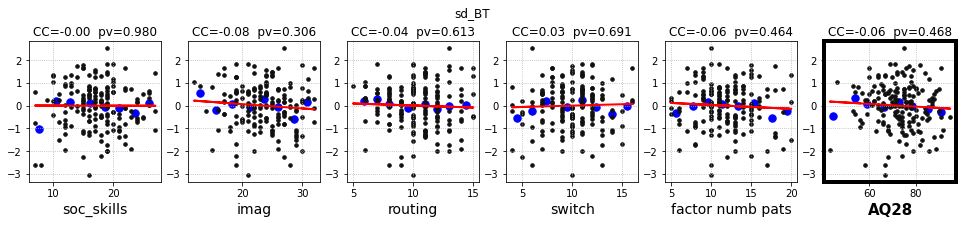

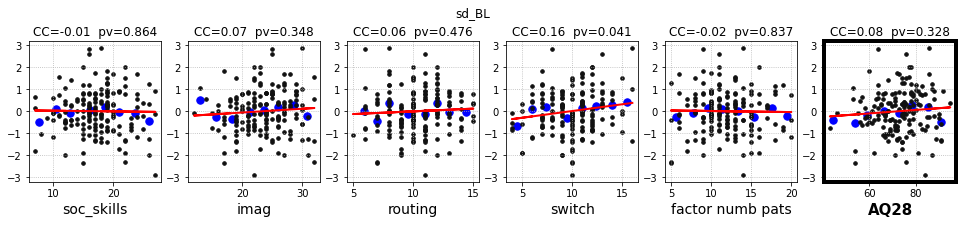

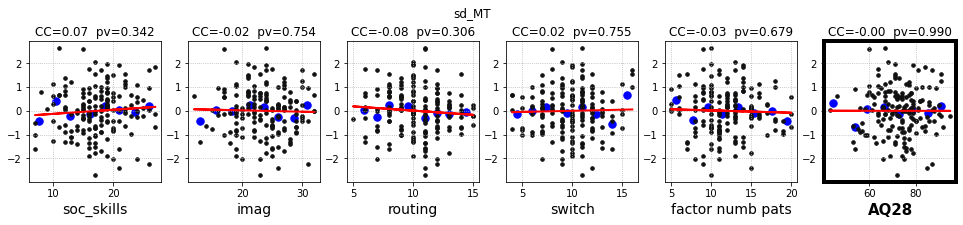

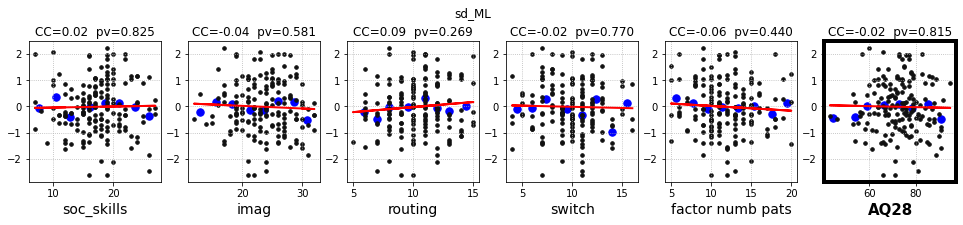

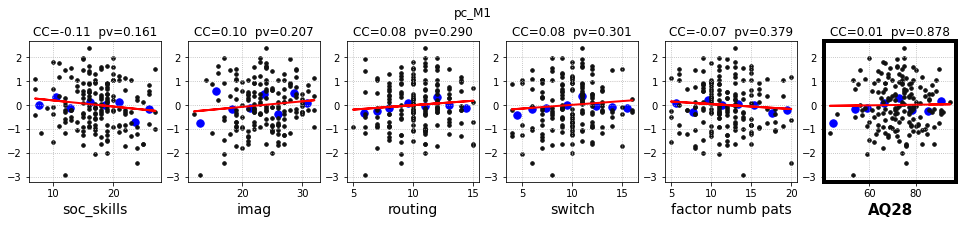

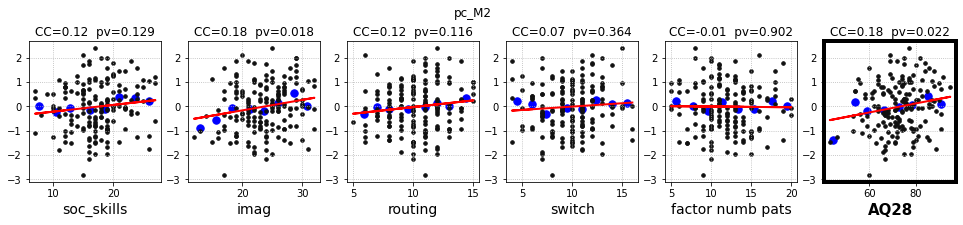

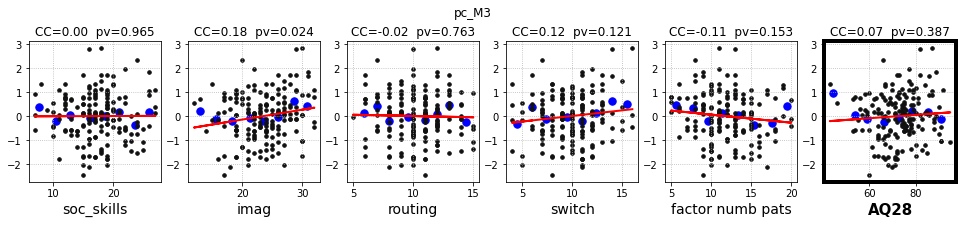

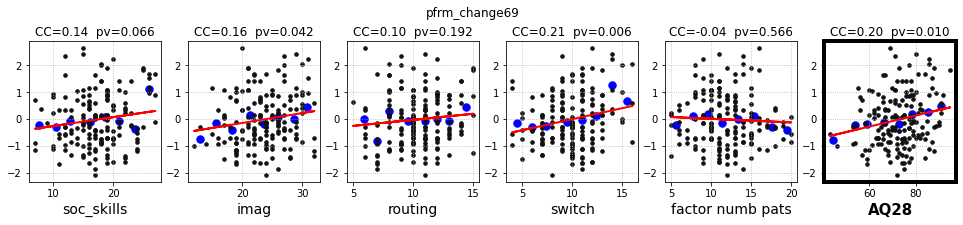

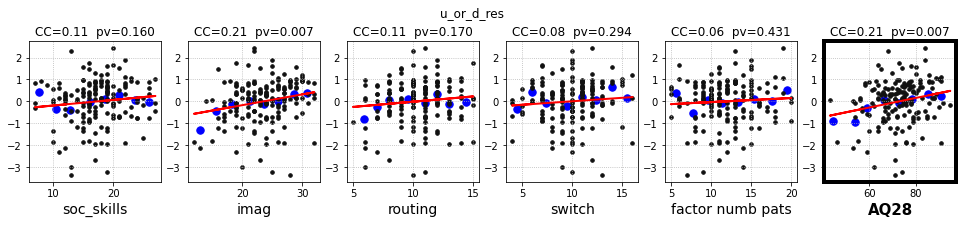

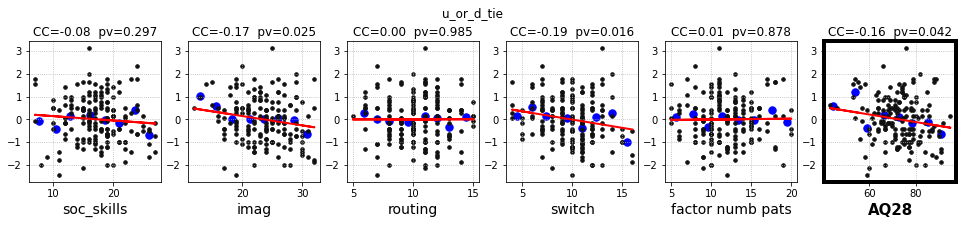

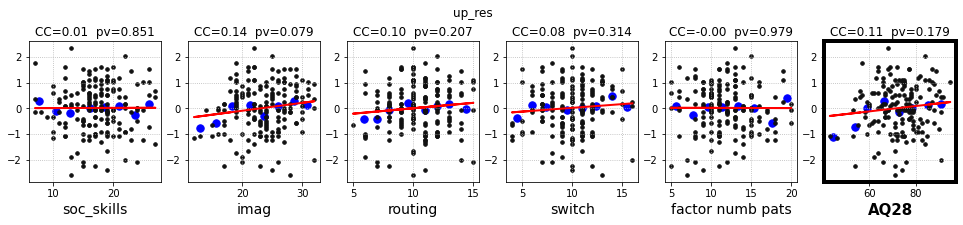

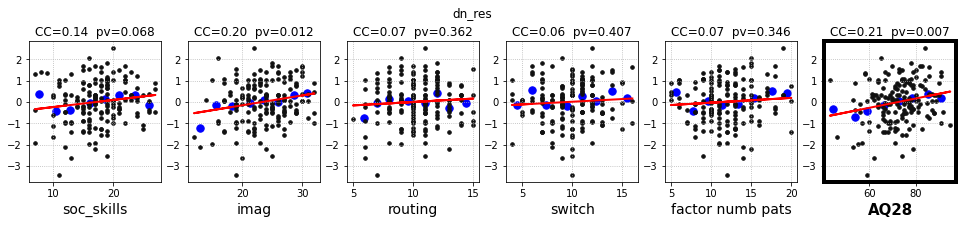

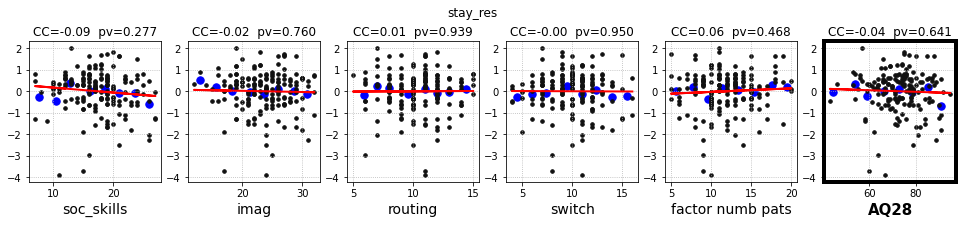

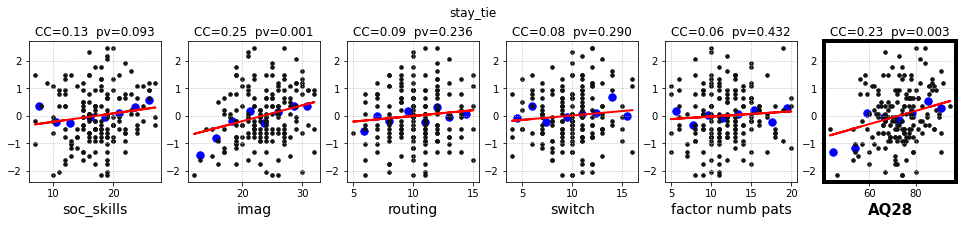

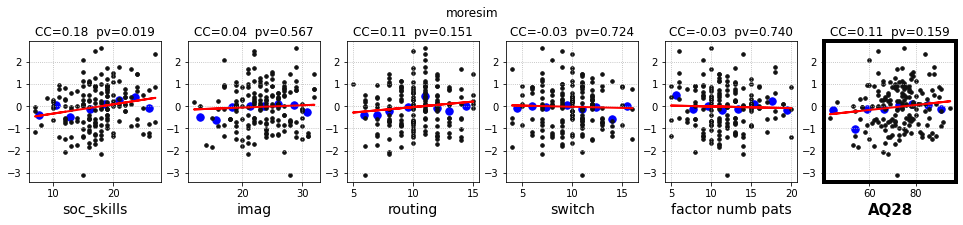

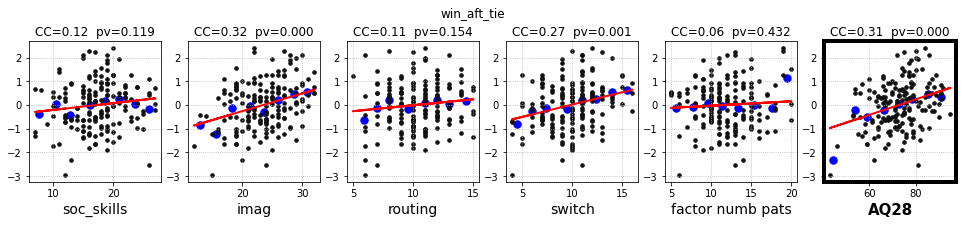

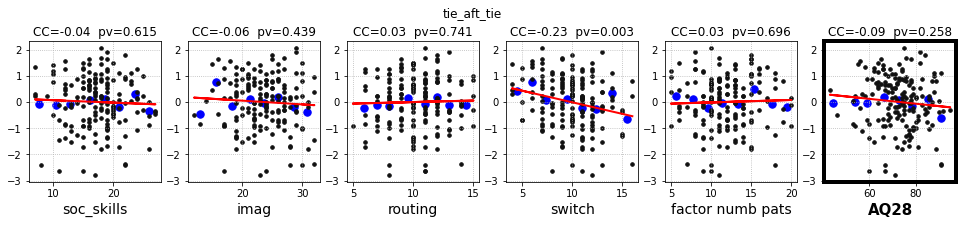

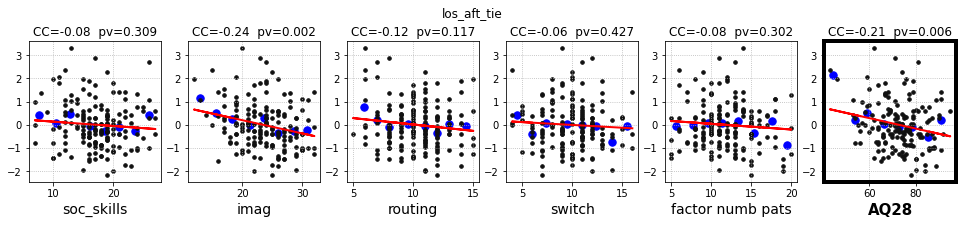

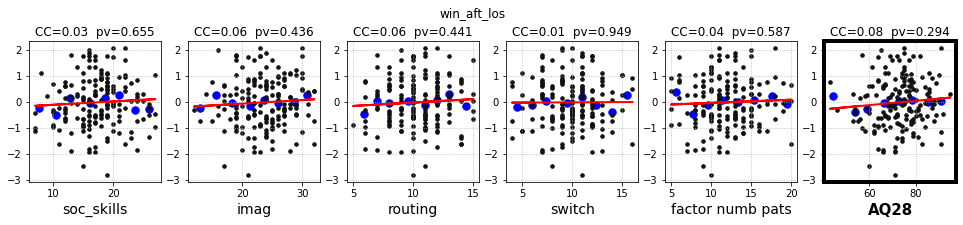

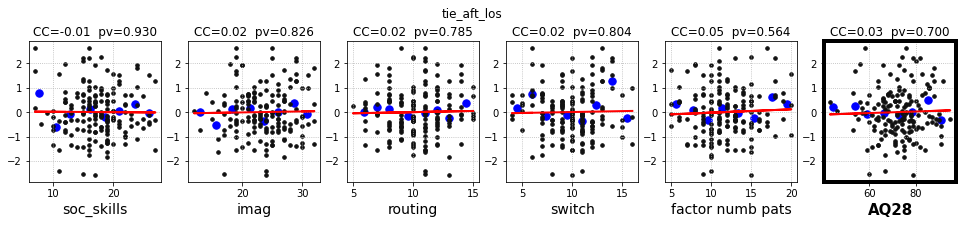

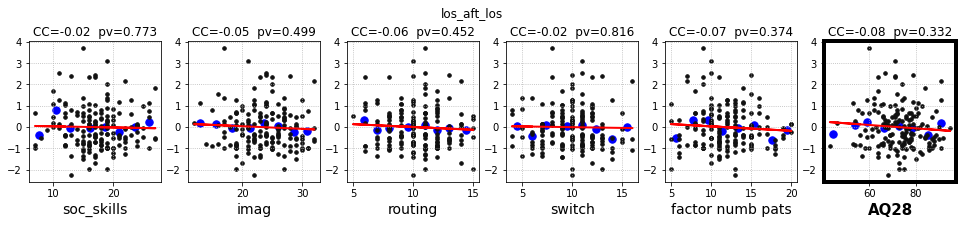

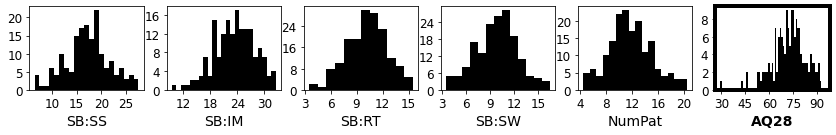

In [16]:
#################################################################################
lm = depickle("/content/AIiRPS/predictAQ28dat/AQ28_vs_RPS.dmp")

look_at_AQ    = True

###############  IDs of participants
partIDs       = eval("lm[\"partIDs\"]")
###############  label for data  - parameters used for CAB calculation
label         = eval("lm[\"label\"]")
data = lm["data"]                #  expteriment name (TMB2)
###############  inferred CRs, CAB
marginalCRs   = eval("lm[\"marginalCRs\"]")
all_prob_mvsA = eval("lm[\"all_prob_mvsA\"]")   #  CAB for each participant
###############  AQ-Short and its factors
AQ28scrs      = eval("lm[\"AQ28scrs\"]")
soc_skils     = eval("lm[\"soc_skils\"]")
imag          = eval("lm[\"imag\"]")
rout          = eval("lm[\"rout\"]")
switch        = eval("lm[\"switch\"]")
fact_pat      = eval("lm[\"fact_pat\"]")
###############  rule-change triggered means per participant

features_cab = lm["features_cab"]
features_stat = lm["features_stat"]

cmp_againsts = features_cab + features_stat
for ca in cmp_againsts:
    exec("%(ca)s = lm[\"%(ca)s\"]" % {"ca" : ca})


nDAT = len(partIDs)
nDAThlf = nDAT//2
allInds = _N.arange(nDAT)

show_mn = True
mn_mode = 2

winsz=15

for ca in cmp_againsts:
    exec("temp = lm[\"%(ca)s\"]" % {"ca" : ca})
    exec("%(ca)s = lm[\"%(ca)s\"]" % {"ca" : ca})    
    if ca[0:7] == "entropy":
        exec("temp = unskew(temp)" % {"ca" : ca})
    exec("%(ca)s = standardize(temp)" % {"ca" : ca})




###################  AQ28scr outliers   takes out 2 participants, but dramatically improves Corr Coeff.
ths = _N.where((AQ28scrs > 35) & (rout > 4))[0]
#ths = _N.where((AQ28scrs > 35))[0]

if look_at_AQ:
    pcpvs = {}
    for cmp_against in cmp_againsts:
        pcs = _N.empty(6)
        pvs = _N.empty(6)
        pcpvs[cmp_against] = [pcs, pvs]
        cmp_vs = eval(cmp_against)

        _AQ28scrs   = AQ28scrs[ths]
        _cmp_vs     = cmp_vs[ths]
        _soc_skils  = soc_skils[ths]
        _rout       = rout[ths]
        _imag       = imag[ths]
        _switch     = switch[ths]
        _fact_pat   = fact_pat[ths]
        dat = _N.empty((len(ths), 2))

        fig = _plt.figure(figsize=(14, 3))
        fig.add_subplot(1, 6, 1)
        _plt.xlabel("soc_skills", fontsize=14)
        #_plt.ylabel(cmp_against)
        xm, ym = wnd_mean(_soc_skils, _cmp_vs, winsz=winsz, mode=mn_mode)
        if show_mn:
            _plt.scatter(xm, ym, marker="o", s=55, color="blue")
        pc, pv = _ss.pearsonr(_soc_skils, _cmp_vs)
        pcs[0] = pc
        pvs[0] = pv
        rmvd, xI, yI = rm_outliersCC(_soc_skils, _cmp_vs)
        _plt.scatter(xI, yI, marker=".", s=50, color="#111111")                
        slope, intercept, pcI, pvI, std_err = _ss.linregress(xI, yI)
        _plt.plot(xI, slope*xI + intercept, color="red", lw=2)        
        _plt.title("CC=%(pc).2f  pv=%(pv).3f" % {"pc" : pc, "pv" : pv, "pcI" : pcI, "pvI" : pvI, "rm" : rmvd})
        _plt.grid(ls=":")
        dat[:, 0] = _soc_skils
        dat[:, 1] = _cmp_vs
        #dmp_dat[cmp_against] = _N.array(dat[:, 1])
        #################################
        fig.add_subplot(1, 6, 2)
        _plt.xlabel("imag", fontsize=14)
        #_plt.ylabel(cmp_against)
        xm, ym = wnd_mean(_imag, _cmp_vs, winsz=winsz, mode=mn_mode)
        if show_mn:
            _plt.scatter(xm, ym, marker="o", s=55, color="blue")
        pc, pv = _ss.pearsonr(_imag, _cmp_vs)
        pcs[1] = pc
        pvs[1] = pv        
        rmvd, xI, yI = rm_outliersCC(_imag, _cmp_vs)
        _plt.scatter(xI, yI, marker=".", s=50, color="#111111")                
        slope, intercept, pcI, pvI, std_err = _ss.linregress(xI, yI)
        _plt.plot(xI, slope*xI + intercept, color="red", lw=2)        
        _plt.title("CC=%(pc).2f  pv=%(pv).3f" % {"pc" : pc, "pv" : pv, "pcI" : pcI, "pvI" : pvI, "rm" : rmvd})
        _plt.grid(ls=":")
        dat[:, 0] = _imag
        dat[:, 1] = _cmp_vs
        #dmp_dat["imag_%s" % cmp_against] =  _N.array(dat)
        #################################        
        fig.add_subplot(1, 6, 3)
        _plt.xlabel("routing", fontsize=14)
        #_plt.ylabel(cmp_against)
        xm, ym = wnd_mean(_rout, _cmp_vs, winsz=winsz, mode=mn_mode)
        if show_mn:
            _plt.scatter(xm, ym, marker="o", s=55, color="blue")
        pc, pv = _ss.pearsonr(_rout, _cmp_vs)
        pcs[2] = pc
        pvs[2] = pv
        #pcI, pvI = rm_outliersCC(_rout, _cmp_vs)
        rmvd, xI, yI = rm_outliersCC(_rout, _cmp_vs)
        _plt.scatter(xI, yI, marker=".", s=50, color="#111111")                
        slope, intercept, pcI, pvI, std_err = _ss.linregress(xI, yI)
        _plt.plot(xI, slope*xI + intercept, color="red", lw=2)
        _plt.title("CC=%(pc).2f  pv=%(pv).3f" % {"pc" : pc, "pv" : pv, "pcI" : pcI, "pvI" : pvI, "rm" : rmvd})
        _plt.grid(ls=":")
        dat[:, 0] = _rout
        dat[:, 1] = _cmp_vs
        #dmp_dat["rout_%s" % cmp_against] = _N.array(dat)
        
        #################################
        fig.add_subplot(1, 6, 4)
        _plt.xlabel("switch", fontsize=14)
        #_plt.ylabel(cmp_against)
        xm, ym = wnd_mean(_switch, _cmp_vs, winsz=winsz, mode=mn_mode)
        if show_mn:
            _plt.scatter(xm, ym, marker="o", s=55, color="blue")
        pc, pv = _ss.pearsonr(_switch, _cmp_vs)
        pcs[3] = pc
        pvs[3] = pv
        rmvd, xI, yI = rm_outliersCC(_switch, _cmp_vs)
        _plt.scatter(xI, yI, marker=".", s=50, color="#111111")                
        slope, intercept, pcI, pvI, std_err = _ss.linregress(xI, yI)
        _plt.plot(xI, slope*xI + intercept, color="red", lw=2)        
        _plt.title("CC=%(pc).2f  pv=%(pv).3f" % {"pc" : pc, "pv" : pv, "pcI" : pcI, "pvI" : pvI, "rm" : rmvd})             
        _plt.grid(ls=":")
        dat[:, 0] = _switch
        dat[:, 1] = _cmp_vs
        #dmp_dat["switch_%s" % cmp_against] =  _N.array(dat)
        
        #################################        
        fig.add_subplot(1, 6, 5)
        _plt.xlabel("factor numb pats", fontsize=14)
        #_plt.ylabel(cmp_against)
        xm, ym = wnd_mean(_fact_pat, _cmp_vs, winsz=winsz, mode=mn_mode)
        if show_mn:
            _plt.scatter(xm, ym, marker="o", s=55, color="blue")
        pc, pv = _ss.pearsonr(_fact_pat, _cmp_vs)
        pcs[4] = pc
        pvs[4] = pv        
        #pcI, pvI = rm_outliersCC(_fact_pat, _cmp_vs)
        rmvd, xI, yI = rm_outliersCC(_fact_pat, _cmp_vs)
        _plt.scatter(xI, yI, marker=".", s=50, color="#111111")                
        slope, intercept, pcI, pvI, std_err = _ss.linregress(xI, yI)
        _plt.plot(xI, slope*xI + intercept, color="red", lw=2)        
        _plt.title("CC=%(pc).2f  pv=%(pv).3f" % {"pc" : pc, "pv" : pv, "pcI" : pcI, "pvI" : pvI, "rm" : rmvd})             
        _plt.grid(ls=":")
        dat[:, 0] = _fact_pat
        dat[:, 1] = _cmp_vs
        #dmp_dat["fact_pat_%s" % cmp_against] = _N.array(dat)
        
        #################################        
        ax = fig.add_subplot(1, 6, 6)
        _plt.xlabel("AQ28", fontsize=15, fontweight="bold")
        #_plt.ylabel(cmp_against)
        xm, ym = wnd_mean(_AQ28scrs, _cmp_vs, winsz=winsz, mode=mn_mode)
        if show_mn:
            _plt.scatter(xm, ym, marker="o", s=55, color="blue")
        pc, pv = _ss.pearsonr(_AQ28scrs, _cmp_vs)
        pcs[5] = pc
        pvs[5] = pv        
        rmvd, xI, yI = rm_outliersCC(_AQ28scrs, _cmp_vs)
        _plt.scatter(xI, yI, marker=".", s=50, color="#111111")        
        slope, intercept, pcI, pvI, std_err = _ss.linregress(xI, yI)
        _plt.plot(xI, slope*xI + intercept, color="red", lw=2)        
        _plt.title("CC=%(pc).2f  pv=%(pv).3f" % {"pc" : pc, "pv" : pv, "pcI" : pcI, "pvI" : pvI, "rm" : rmvd})             
        _plt.grid(ls=":")
        dat[:, 0] = _AQ28scrs
        dat[:, 1] = _cmp_vs
        #dmp_dat["AQ28_%s" % cmp_against] = _N.array(dat)

        ax.spines["left"].set_linewidth(4)
        ax.spines["right"].set_linewidth(4)
        ax.spines["top"].set_linewidth(4)
        ax.spines["bottom"].set_linewidth(4)        
        fig.subplots_adjust(hspace=0.4, left=0.06, bottom=0.17, top=0.82, right=0.98)
        _plt.suptitle("%(vs)s" % {"vs" : cmp_against})
        _plt.savefig("AQ_vs_%(vs)s_%(lb)d" % {"vs":cmp_against, "lb":label})
        #_plt.close()


AQ28subs = ["SB:SS", "SB:IM", "SB:RT", "SB:SW", "NumPat", "AQ28"]

fig = _plt.figure(figsize=(13, 2))
ic  = 0
for cat in [soc_skils, imag, rout, switch, fact_pat]:
    ic += 1
    ax = fig.add_subplot(1, 6, ic)
    bns = _N.linspace(_N.min(cat)-0.5, _N.max(cat)+0.5, int(_N.max(cat) - _N.min(cat)+2))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    _plt.locator_params(axis='x', nbins=5)
    _plt.locator_params(axis='y', nbins=5)        
    _plt.hist(cat, bins=bns, color="black")
    # if cat is soc_skils:
    #     _plt.xticks(_N.arange(6, 25, 6))
    # elif cat is imag:
    #     _plt.xticks(_N.arange(9, 34, 6))
    # elif (cat is rout) or (cat is switch):
    #     _plt.xticks(_N.arange(4, 17, 4))
    # elif (cat is fact_pat):
    #     _plt.xticks(_N.arange(4, 21, 5))
        
    _plt.xlabel(AQ28subs[ic-1], fontsize=14)
    _plt.yticks(fontsize=12)
    _plt.xticks(fontsize=12)        
        
_plt.hist(cat, bins=bns, color="black")
ax = fig.add_subplot(1, 6, 6)
cat = AQ28scrs
bns = _N.arange(_N.min(cat)-0.5, _N.max(cat)+0.5, 1)
_plt.hist(cat, bins=bns, color="black")
ax.spines["left"].set_linewidth(4)
ax.spines["right"].set_linewidth(4)
ax.spines["top"].set_linewidth(4)
ax.spines["bottom"].set_linewidth(4)
#  https://stackoverflow.com/questions/6682784/reducing-number-of-plot-ticks
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
_plt.locator_params(axis='y', nbins=5)
_plt.locator_params(axis='x', nbins=5)
_plt.yticks(fontsize=12)
_plt.xticks(fontsize=12)

#_plt.xticks(_N.arange(30, 96, 10))
_plt.xlabel(AQ28subs[5], fontsize=14, fontweight="bold")
ax = fig.subplots_adjust(bottom=0.24, top=0.82, right=0.98, hspace=0.18)
_plt.savefig("TMB2_AQ_hist", transparent=True)






#  Let's look at linear combination of some CAB features

In [17]:




# fig = _plt.figure(figsize=(10, 10))
# ii = 0
# for i in range(3):
#     for j in range(2):
#         ii+= 1
#         fig.add_subplot(3, 2, ii)
#         _plt.scatter(cond_distinguished[:, j], stay_amps[:, i])

#  entropyL - entropyW  (SW)
#  entropyL - entropyS  (SW)
#  entropyL + entropyW  (fact_pat)


cmbs = ["entropyL - entropyW", "entropyL + entropyW",
        "entropyL - entropyT", "entropyL + entropyT",
        "entropyW - entropyT", "entropyW + entropyT",  
        #################      
        "entropyT - entropyS", "entropyT + entropyS", 
        "entropyT - entropyD", "entropyT + entropyD", 
        "entropyT - entropyU", "entropyT + entropyU",
        ################# 
        "entropyL - entropyS", "entropyL + entropyS", 
        "entropyL - entropyD", "entropyL + entropyD", 
        "entropyL - entropyU", "entropyL + entropyU", 
        ################# 
        "entropyW - entropyS", "entropyW + entropyS", 
        "entropyW - entropyD", "entropyW + entropyD",
        "entropyW - entropyU", "entropyW + entropyU",
        ]




AQfacs = ["soc_skils", "imag", "rout", "switch", "fact_pat", "AQ28scrs"]

for saqf in AQfacs:
    print("*********Factor %s" % saqf)
    aqf = eval(saqf)
    for scmb in cmbs:
        exec("feat = %s" % scmb)
        pc1, pv1 = _ss.pearsonr(aqf[ths], feat[ths])
        ss1 = "**" if pv1 < 0.05 else ""
        print("%(sc)s   %(1) .3f  %(2).3f  %(3)s" % {"1" : pc1, "2" : pv1, "3" : ss1, "sc" : scmb})

    



*********Factor soc_skils
entropyL - entropyW   -0.036  0.644  
entropyL + entropyW   -0.062  0.428  
entropyL - entropyT   -0.083  0.288  
entropyL + entropyT   -0.018  0.815  
entropyW - entropyT   -0.056  0.473  
entropyW + entropyT    0.012  0.876  
entropyT - entropyS    0.015  0.851  
entropyT + entropyS    0.046  0.553  
entropyT - entropyD    0.091  0.248  
entropyT + entropyD   -0.016  0.839  
entropyT - entropyU    0.097  0.215  
entropyT + entropyU   -0.028  0.722  
entropyL - entropyS   -0.086  0.275  
entropyL + entropyS   -0.028  0.722  
entropyL - entropyD   -0.001  0.987  
entropyL + entropyD   -0.092  0.240  
entropyL - entropyU    0.011  0.886  
entropyL + entropyU   -0.105  0.179  
entropyW - entropyS   -0.041  0.599  
entropyW + entropyS   -0.000  0.998  
entropyW - entropyD    0.043  0.579  
entropyW + entropyD   -0.055  0.484  
entropyW - entropyU    0.047  0.550  
entropyW + entropyU   -0.073  0.352  
*********Factor imag
entropyL - entropyW   -0.021  0.788  
ent

#  Does our data have a lot of outliers?

Text(0, 0.5, 'SS:SWitch')

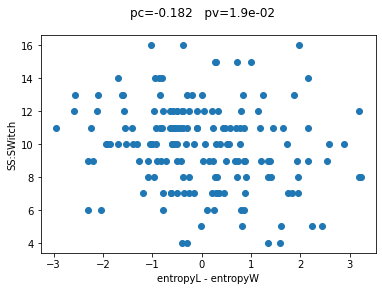

In [18]:
eLmW = entropyL - entropyW
_plt.scatter(eLmW[ths], switch[ths])
pc, pv = _ss.pearsonr(eLmW[ths], switch[ths])
_plt.suptitle("pc=%(pc).3f   pv=%(pv).1e" % {"pc" : pc, "pv" : pv})
_plt.xlabel("entropyL - entropyW")
_plt.ylabel("SS:SWitch")

Text(0, 0.5, 'SS:SWitch')

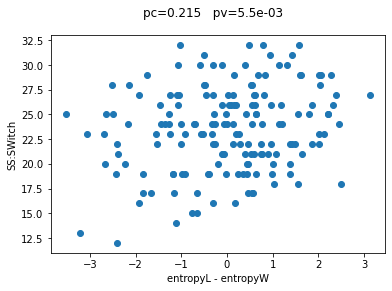

In [19]:


eTmU = entropyT - entropyU
_plt.scatter(eTmU[ths], imag[ths])
pc, pv = _ss.pearsonr(eTmU[ths], imag[ths])
_plt.suptitle("pc=%(pc).3f   pv=%(pv).1e" % {"pc" : pc, "pv" : pv})
_plt.xlabel("entropyL - entropyW")
_plt.ylabel("SS:SWitch")

Text(0, 0.5, 'SS:SWitch')

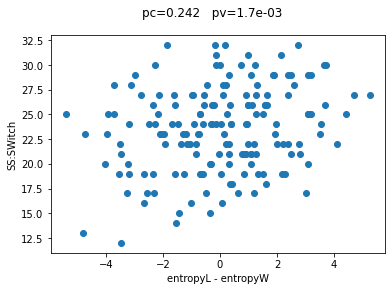

In [20]:
z_win_aft_tie = win_aft_tie - _N.mean(win_aft_tie)
mm_win_aft_tie = z_win_aft_tie/_N.std(z_win_aft_tie)

z_stay_tie = stay_tie - _N.mean(stay_tie)
mm_stay_tie = z_stay_tie/_N.std(z_stay_tie)

eTmUs = entropyTs - 2*entropyUs# + 0.6*moresim + 3.5*mm_win_aft_tie + 0.9*mm_stay_tie
_plt.scatter(eTmUs[ths], imag[ths])
pc, pv = _ss.pearsonr(eTmUs[ths], imag[ths])
_plt.suptitle("pc=%(pc).3f   pv=%(pv).1e" % {"pc" : pc, "pv" : pv})
_plt.xlabel("entropyL - entropyW")
_plt.ylabel("SS:SWitch")